# Demo to test the functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random
import cv2
import warnings
import math
from tabulate import tabulate
from tqdm import tqdm
import scipy.io as sio

In [2]:
# Load a .mat file as a dataframe named 'data'
def load_mat(filename):
    mat = sio.loadmat(filename)
    return mat

filename='../dataSets/TorontoScenes/mountains_vecLD.mat'
data = load_mat(filename)

In [3]:
# Given the above keys, we access 77th row of the data
data_keys = {'originalImage','imsize', 'lineMethod', 'numContours',                
            'contours', 'orientations', 'lengths',   'contourLengths',             
            'curvatures', 'junctions', 'parallelism',  'parallelismMeans',           
            'parallelism_allX', 'parallelism_allY','parallelism_allScores', 
            'parallelismBins', 'parallelismHistograms', 'parallelismNormHistograms',  
            'parallelismSumHistogram', 'parallelismNormSumHistogram',
            'separation', 'separationMeans', 'separation_allX',  'separation_allY',            
            'separation_allScores', 'separationBins',             
            'separationHistograms', 'separationNormHistograms',   
            'separationSumHistogram', 'separationNormSumHistogram', 
            'mirror', 'mirrorMeans', 'mirror_allX', 'mirror_allY',                
            'mirror_allScores', 'mirrorBins', 'mirrorHistograms', 
            'mirrorNormHistograms', 'mirrorSumHistogram', 'mirrorNormSumHistogram'}

cute = {}
# Assign the data to the dictionary and define them with empty value
for key in data_keys:
    cute[key] = data['vecLD'][key][0][10]
print(cute['contours'][0].shape)

(34,)


In [4]:
from drawLinedrawing import drawLinedrawing
from rotateLinedrawing import rotateLinedrawing

from unique import unique1D, unique2D, unique3D
from load_mat import load_mat

### RotateLineDrawing

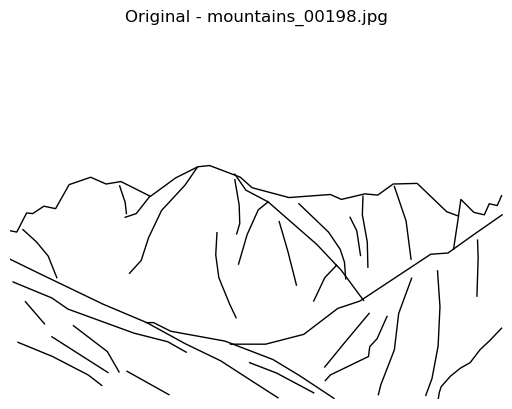

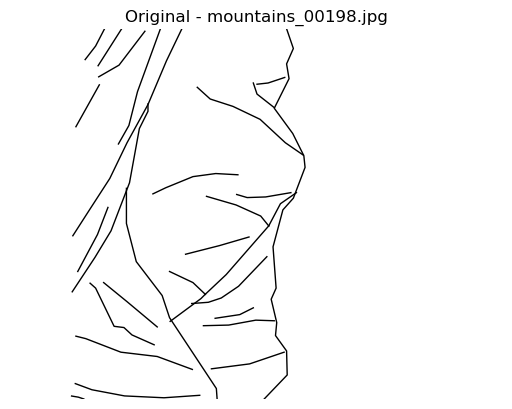

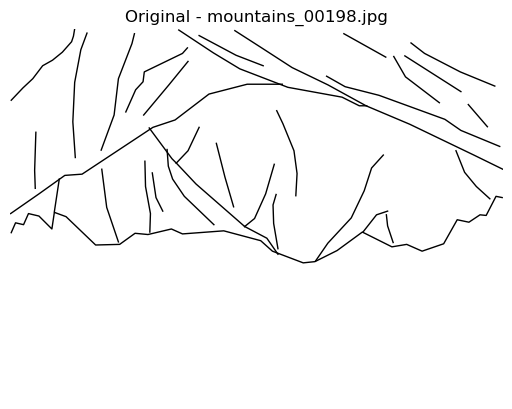

In [13]:
drawLinedrawing(cute)
rotateLD = rotateLinedrawing(cute, 90)
# print("Rotated by 90 degrees")
drawLinedrawing(rotateLD)
rotateLD = rotateLinedrawing(cute, 180)
# print("Rotated by 180 degrees")
drawLinedrawing(rotateLD)

### Average Property

In [ ]:
def averageProperty(vecLD,property):

    if property.lower() == 'orientation':
        # For orientation, all line segments get concatenated
        totalVec = np.array([0.0, 0.0])
        for c in range(cute['numContours'][0][0]):
            theseVec = cute['contours'][0][c][:, 3:4] - cute['contours'][0][c][:, 1:2]

            reverseIdx = cute['orientations'][0][c] > 180
            reverseIdx = reverseIdx.flatten()
            theseVec[reverseIdx, :] = -theseVec[reverseIdx, :]
            # 'totalVec' is now a float array, and summing 'theseVec' doesn't cause type issues
            totalVec += np.sum(theseVec, axis=0).flatten()

        meanProperty = math.degrees(math.atan2(-totalVec[1], totalVec[0])) % 180
        print(meanProperty)


    elif property.lower() == 'length':
        meanProperty = np.mean(vecLD['contourLengths'])

    elif property.lower() == 'curvature':
        meanProperty = 0
        for c in range(vecLD['numContours'][0][0]):
            meanProperty = meanProperty + sum(vecLD['curvatures'][0][c] * vecLD['lengths'][c])
        meanProperty = meanProperty / sum(vecLD['contourLengths'])

    elif property.lower() == 'junctions':
        meanProperty = sum(vecLD['normJunctionTypeHistogram'])

    elif property.lower() == 'mirror':
        meanProperty = np.mean(vecLD['mirror_allScores'])

    elif property.lower() == 'parallelism':
        meanProperty = np.mean(vecLD['parallelism_allScores'])

    elif property.lower() == 'separation':
        meanProperty = np.mean(vecLD['separation_allScores'])

    else:
        raise ValueError('Unknown property string: ' + property)
    

    return meanProperty

### LineIntersection

In [ ]:
from lineIntersection import lineIntersection

In [41]:
lineIntersection(cute['contours'][0][1][0], cute['contours'][0][1][1])

array([0.94754118, 0.28459674])

### applyCircularAperture

In [56]:
cute['imsize'][0]
np.min(cute['imsize'][0])

600

In [76]:
def applyCircularAperture(vecLD,radius=None):
    if radius is None:
        radius = np.min(vecLD['imsize'][0]) / 2

    # Prep the new data structure
    maskedLD = {}
    maskedLD['originalImage'] = vecLD['originalImage']
    maskedLD['imsize'] = vecLD['imsize']
    maskedLD['lineMethod'] = vecLD['lineMethod']
    maskedLD['numContours'] = 0
    maskedLD['contours'] = []
    print("Original Image: ",maskedLD['originalImage'])
    print("Image Size: ",maskedLD['imsize'])
    print("Line Method: ",maskedLD['lineMethod'])
    print("Number of Contours: ",maskedLD['numContours'])
    # print("Contours: ",vecLD['contours'])

    center = np.array(vecLD['imsize'][0]) / 2
    print("Center: ",center)
    
    for c in range(vecLD['numContours'][0][0]):
        # Compute distances of all contour points from the center
        A = vecLD['contours'][0][c][:, 0:2]
        B = vecLD['contours'][0][c][:, 2:4]
        rA = np.sqrt(np.sum((A - center)**2, axis=1))
        rB = np.sqrt(np.sum((B - center)**2, axis=1))
        print("A: ",A)
        print("B: ",B)
        print("rA: ",rA)
        print("rB: ",rB)

        prevInside = rA[0] <= radius
        print("Previous Inside: ",prevInside)
        currContour = []
        for s in range(vecLD['contours'][0][c].shape[0]):
            currInside = rB[s] <= radius
            # if end points are on different sides, compute the intersection point with the circle
            if currInside ^ prevInside: # Review this
                # Length of segment
                d = np.sqrt(np.sum((B[s, :] - A[s, :])**2))
                # Solve the quadratic equation
                p = -d - ((rA[s]**2 - rB[s]**2) / d)
                q = rA[s]**2 - radius**2
                QQ = np.sqrt((p / 2)**2 - q)
                dA1 = -(p / 2) + QQ
                dA2 = -(p / 2) - QQ

                # Make sure we pick the right solution
                dA1valid = (0 <= dA1) & (dA1 <= d)
                dA2valid = (0 <= dA2) & (dA2 <= d)
                if dA1valid:
                    dA = dA1
                    if dA2valid:
                        warnings.warn('Two valid solution - don''t know which one to pick.')
                elif dA2valid:
                    dA = dA2
                else:
                    warnings.warn('No valid solution - don''t know what to do.')

                # Compute the intersection point
                C = A[s, :] + (dA / d) * (B[s, :] - A[s, :])

            # consider all 4 cases
            if prevInside:
                if currInside:
                    # we are completely inside the circle - just keep the segment
                    currContour.append(vecLD['contours'][0][c][s, :])
                else:
                    # going from inside to outside the circle
                    # break the segment and terminate this contour
                    currContour = np.concatenate([currContour, np.array([A[s,:] , C])])
                    maskedLD['numContours'] = maskedLD['numContours'] + 1
                    #Print size of maskedLD['contours'] and numContours
                    print("Size of Masked Contours: ",maskedLD['contours'].shape, "Number of Contours: ",maskedLD['numContours'])
                    maskedLD['contours'][maskedLD['numContours'] - 1] = currContour # Review this
                    currContour = []
            else:
                if currInside:
                    # going from outside to inside the circle
                    # break the segment and start a new contour
                    currContour = np.array([C, B[s, :]])
                    maskedLD['numContours'] = maskedLD['numContours'] + 1
                    print("Size of Masked Contours: ",maskedLD['contours'].shape, "Number of Contours: ",maskedLD['numContours'])
                    maskedLD['contours'][maskedLD['numContours'] - 1] = currContour
                    currContour = []
                else:
                    # we are completely outside the circle - just ignore this segment
                    pass
                
            prevInside = currInside

        # Save the contour if it is not empty
        if len(currContour) > 0:
            maskedLD['numContours'] = maskedLD['numContours'] + 1
            print("Size of Masked Contours: ",maskedLD['contours'].shape, "Number of Contours: ",maskedLD['numContours'])
            maskedLD['contours'][maskedLD['numContours'] - 1] = currContour

    return maskedLD

In [77]:
applyCircularAperture(cute)

Original Image:  ['mountains_00198.jpg']
Image Size:  [[800 600]]
Line Method:  ['artist']
Number of Contours:  0
Center:  [400. 300.]
A:  [[798. 485.]
 [779. 505.]
 [763. 520.]
 [747. 541.]
 [731. 550.]
 [715. 563.]
 [700. 580.]
 [697. 589.]]
B:  [[779.         505.        ]
 [763.         520.        ]
 [747.         541.        ]
 [731.         550.        ]
 [715.         563.        ]
 [700.         580.        ]
 [697.         589.        ]
 [695.16666667 600.        ]]
rA:  [438.89520389 430.88977709 424.46319039 422.48076879 414.80236258
 410.35837996 410.36569057 414.40318532]
rB:  [430.88977709 424.46319039 422.48076879 414.80236258 410.35837996
 410.36569057 414.40318532 420.86026316]
Previous Inside:  False
A:  [[  1 327]
 [ 11 329]
 [ 27 298]
 [ 37 299]
 [ 55 287]
 [ 74 291]
 [ 96 252]
 [131 240]
 [156 251]
 [180 247]
 [228 271]
 [269 241]
 [305 223]
 [324 221]
 [374 240]
 [393 257]
 [453 273]
 [520 268]
 [538 276]
 [576 267]
 [597 269]
 [622 251]
 [661 250]
 [709 296]
 [7

AttributeError: 'list' object has no attribute 'shape'

### removeZeroLengthContours

In [5]:
import numpy as np
import warnings
from computeLength import computeLength
from removeZeroLengthContours import removeZeroLengthContours

In [100]:
removeZeroLengthContours(cute)[0]['contours'][0]

array([[798.        , 485.        , 779.        , 505.        ],
       [779.        , 505.        , 763.        , 520.        ],
       [763.        , 520.        , 747.        , 541.        ],
       [747.        , 541.        , 731.        , 550.        ],
       [731.        , 550.        , 715.        , 563.        ],
       [715.        , 563.        , 700.        , 580.        ],
       [700.        , 580.        , 697.        , 589.        ],
       [697.        , 589.        , 695.16666667, 600.        ]])

### getDistanceFromLineSegment

In [5]:
from getDistanceFromLineSegment import getDistanceFromLineSegment

In [6]:
XY = np.array([[0.0, 0.0], [1.3, 1.0], [2.6, 2.35], [3.0, 3.25], [4.0, 4.0]])
getDistanceFromLineSegment(XY)


0.18856180831641267

### histogramToTable

In [5]:
from histogramToTable import histogramToTable

In [128]:
histogram = np.array([[1,2,3,1],[4,5,6,2],[7,8,9,4]])
histogramToTable(histogram,'col',bins=["a","b","c","d"])

col_a  col_b  col_c  col_d
0      1      2      3      1
1      4      5      6      2
2      7      8      9      4

### getMATpropertyStats

In [9]:
from getMATpropertyStats import getMATpropertyStats

In [197]:
vecLD1, hist1, bins1, shortName1 = getMATpropertyStats(cute, 'parallelism')
print("Parallelism Bins: ",bins1, "\nParallelism Histogram: ",hist1, "\nShort Name: ",shortName1)
print("parallelismSumHistogram: ",vecLD1['parallelismSumHistogram'])
print("parallelismNormSumHistogram: ",vecLD1['parallelismNormSumHistogram'])

Parallelism Bins:  [0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375] 
Parallelism Histogram:  [ 136.  282.  204.  417.  357.  825. 1557. 1367.] 
Short Name:  par
parallelismSumHistogram:  [ 136.  282.  204.  417.  357.  825. 1557. 1367.]
parallelismNormSumHistogram:  [ 232.32500863  481.73273848  348.48751295  712.34947499  609.85314765
 1409.32450088 2659.77969439 2335.20799116]


### allLDHistogramsToTable

In [10]:
from histogramToTable import histogramToTable
from allLDHistogramsToTable import allLDHistogramsToTable

In [11]:
allLDHistogramsToTable(cute, ['parallelismHistograms', 'separationHistograms'], ['par', 'sep', 'mir']).head()

par_1  par_2  par_3  par_4  par_5  par_6  par_7  par_8  sep_1  sep_2  \
0      6      0      0     18     15     21      9      0      0      0   
1     85    190     81    154    102     81    141     24    126     58   
2      0      0      0     16      5     19    151    244     20     28   
3      0      8      5      1      7     50     96    139      0      0   
4      0      2     19     73     79    143     65     56     17      4   

   sep_3  sep_4  sep_5  sep_6  sep_7  sep_8  
0     21     10     14     16      8      0  
1    108    110    128    162    166      0  
2     38    114     58     34    143      0  
3     44     23     87     57     95      0  
4     24     51     95    153     93      0

### MATpropertiesToContours

In [40]:
def MATpropertiesToContours(vecLD, MATpropertyImage, property):
    # Define a vector for scaling the coordinates up or down as needed
    # MATpropertyImage = np.transpose(MATpropertyImage) 
    imsize = (MATpropertyImage.shape[0], MATpropertyImage.shape[1])
    print("Image Size: ",imsize)
    scaleVec = (imsize[1] / vecLD['imsize'][0][0], imsize[0] / vecLD['imsize'][0][1])
    # scaleVec = (vecLD['imsize'][0][1] / imsize[0], vecLD['imsize'][0][0] / imsize[1])
    scaleVec = np.array([scaleVec, scaleVec]).flatten()
    print("Scale Vector: ",scaleVec)
    vecLD[property] = np.zeros(vecLD['numContours'][0][0], dtype=object)
    allMeans = np.zeros(vecLD['numContours'][0][0])
    # Collect all scores for the entire image
    allInd = []
    allProp = []
    for c in range(vecLD['numContours'][0][0]):
        img = np.zeros(imsize, dtype=np.uint8)
        scaledCoords = np.array(vecLD['contours'][0][c]) * scaleVec
        # Convert scaledCoords into format expected by cv2.polylines or cv2.line
        scaledCoords = scaledCoords.reshape((-1, 1, 2)).astype(np.int32)
        # Drawing lines on the image
        img = cv2.polylines(img, [scaledCoords], isClosed=False, color=(255,), thickness=1)
        # Finding indices where img > 0
        thisInd = np.where(img > 0)
        thisProp = MATpropertyImage[thisInd].flatten()
        validProp = (thisProp != 0)
        # Calculating mean of valid properties
        allMeans[c] = np.mean(thisProp[validProp]) if np.any(validProp) else np.nan
        thisProp[~validProp] = np.nan
        # Updating vecLD with properties for this contour
        if property not in vecLD:
            vecLD[property] = []
        vecLD[property].append(thisProp)
        # Accumulating indices and properties
        allInd.extend(thisInd[0][validProp])
        allProp.extend(thisProp[validProp])
    # Update vecLD with the means for each contour property
    vecLD[f'{property}Means'] = allMeans
    # Convert linear indices (allInd) to subscript indices
    Y, X = np.unravel_index(allInd, imsize)
    # Update vecLD with X, Y coordinates and all property scores
    vecLD[f'{property}_allX'] = X
    vecLD[f'{property}_allY'] = Y
    vecLD[f'{property}_allScores'] = allProp
    return vecLD

MATpropertiesToContours(cute, cute['parallelismHistograms'], 'parallelism')

Image Size:  (34, 8)
Scale Vector:  [0.01       0.05666667 0.01       0.05666667]
Scaled Coords:  [[[ 7 27]]

 [[ 7 28]]

 [[ 7 28]]

 [[ 7 29]]

 [[ 7 29]]

 [[ 7 30]]

 [[ 7 30]]

 [[ 7 31]]

 [[ 7 31]]

 [[ 7 31]]

 [[ 7 31]]

 [[ 7 32]]

 [[ 7 32]]

 [[ 6 33]]

 [[ 6 33]]

 [[ 6 34]]]


ValueError: cannot convert float NaN to integer

### cleanupJunctions

In [7]:
from scipy.spatial import KDTree

In [40]:
def recursiveClasses(J, mergeMatrix, isJunctionAvailable):
    print("J: ",J)
    print("Is Junction Available: ",isJunctionAvailable[J])
    if isJunctionAvailable[J]:
        allJs = J
        isJunctionAvailable[J] = False
    else:
        allJs = []
        return allJs, mergeMatrix, isJunctionAvailable

    newJs = np.where(mergeMatrix[J, :])[0] # Verify
    mergeMatrix[J, :] = False
    mergeMatrix[:, J] = False
    for j in range(len(newJs)):
        thisJs, mergeMatrix, isJunctionAvailable = recursiveClasses(newJs[j], mergeMatrix, isJunctionAvailable)
        isJunctionAvailable[thisJs] = False
        allJs = np.concatenate((allJs, thisJs))
    
    return allJs, mergeMatrix, isJunctionAvailable

In [41]:
cute['junctions'][0]['position'][0]

array([[227.28205128, 270.64102564]])

In [42]:
def cleanupJunctions(Junctions, Thresh=2):
    Thresh2 = Thresh**2
    print("Threshold: ",Thresh2)
    # Determine which junctions need to be merged
    mergeMatrix = np.zeros((len(Junctions[0]), len(Junctions[0])), dtype=bool)
    print("Length of junctions: ",len(Junctions[0]))
    for j1 in range(len(Junctions[0])):
        for j2 in range(j1+1, len(Junctions[0])):
            mergeMatrix[j1, j2] = np.sum((Junctions[0]['position'][j2] - Junctions[0]['position'][j2])**2) <= Thresh2
    # Determine equivalence classes
    equivalenceClasses = []
    isJunctionAvailable = np.ones(len(Junctions[0]), dtype=bool)
    while np.any(mergeMatrix[:]): # Verify
        j1, _ = np.where(mergeMatrix) # Verify
        equiClass, mergeMatrix, isJunctionAvailable = recursiveClasses(j1, mergeMatrix, isJunctionAvailable)
        equivalenceClasses.append(equiClass)
    # Double check that they are all disjoint
    equJuncts = np.concatenate(equivalenceClasses)
    uniqueEquJuncts = np.unique(equJuncts)
    if len(uniqueEquJuncts) < len(equJuncts):
        raise ValueError('Error: Equivalence classes are not disjoint')
    # initialize the resulting junctions with all jucntions that do not have neighbors
    cleanedJunctions = Junctions[isJunctionAvailable]
    # Now actually merge junctions that are in equivalence classes
    thisJunct = {}
    for cl in range(len(equivalenceClasses)):
        thisClass = equivalenceClasses[cl]
        allPos = np.array([Junctions[0]['Position'][j] for j in thisClass]) # Verify
        thisJunct['position'] = np.mean(allPos, axis=0) # Use the center of mass between the junction points
        # Combine contour segments
        thisJunct['contourIDs'] = []
        thisJunct['segmentIDs'] = []
        for j in range(len(thisClass)):
            thisCont = Junctions[0]['contourIDs'][thisClass[j]]
            thisSegm = Junctions[0]['segmentIDs']
            for s in range(len(thisCont)):
                # Make sure we don't already have this contour-segment combination
                if (thisCont[s] not in thisJunct['contourIDs']) or (thisSegm[s] not in thisJunct['segmentIDs']):
                    thisJunct['contourIDs'].append(thisCont[s])
                    thisJunct['segmentIDs'].append(thisSegm[s])
        cleanedJunctions.append(thisJunct)
    return cleanedJunctions

cleanupJunctions(cute['junctions'])

Threshold:  4
Length of junctions:  11
J:  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7 8 8 9]
Is Junction Available:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Threshold:  4
Length of junctions:  11


ValueError: no field of name Position

### saveSceneLDsToTable

In [34]:
from getContourPropertiesStats import getContourPropertiesStats
from histogramToTable import histogramToTable
from saveSceneLDsToTable import saveSceneLDsToTable

In [35]:
# vecLD_example = {
#     'originalImage': 'beach_01.png',
#     'curvatures': [np.array([0.1, 0.2, np.nan, 0.3])],  # List of arrays, one per contour
#     'contourLengths': np.array([5.0, 7.2, 4.5])
# }

# # Wrap this in a list to simulate a collection of vecLD objects for the category
# vecLDs_for_category = [vecLD_example]

# # Save this data structure as an .npy file for the 'beaches' category
# np.save('vecLD_beaches.npy', vecLDs_for_category, allow_pickle=True)
# np.save('vecLD_cities.npy', vecLDs_for_category, allow_pickle=True)
# np.save('vecLD_forests.npy', vecLDs_for_category, allow_pickle=True)
# np.save('vecLD_highways.npy', vecLDs_for_category, allow_pickle=True)
# np.save('vecLD_mountains.npy', vecLDs_for_category, allow_pickle=True)
# np.save('vecLD_offices.npy', vecLDs_for_category, allow_pickle=True)

In [37]:
saveSceneLDsToTable('test.csv')


beaches

	0. beach_01.png


cities

	0. beach_01.png


forests

	0. beach_01.png


highways

	0. beach_01.png


mountains

	0. beach_01.png


offices

	0. beach_01.png


min/max Length = 4.5 / 7.2

min/max Curvature = 0.1 / 0.3



KeyError: 'numContours'

### detectJunctions

In [43]:
import numpy as np
import math
import warnings
from lineIntersection import lineIntersection

In [55]:
cute['contourLengths']

array([[158.20191847],
       [963.04954403],
       [490.58972639],
       [333.68667533],
       [501.74628937],
       [207.10092151],
       [ 54.58265359],
       [121.6494362 ],
       [197.74987729],
       [107.91200119],
       [ 77.89736838],
       [304.89865506],
       [107.28146664],
       [ 47.50789408],
       [ 53.60037313],
       [ 72.32904148],
       [149.53084555],
       [115.16990566],
       [154.13004873],
       [112.93133072],
       [ 89.32997587],
       [151.58088913],
       [114.47895253],
       [144.19068616],
       [ 72.1007811 ],
       [ 69.63382053],
       [106.75385449],
       [115.7502149 ],
       [204.93554767],
       [ 91.04948593],
       [ 97.26115892],
       [ 46.57126922],
       [ 65.04424458],
       [153.64143189]])

In [59]:
def detectJunctions(vecLD, AE=1, RE=0.3):
    Junctions = {}
    count = 0
    for queryC in range(vecLD['numContours'][0][0]):
        if vecLD['contourLengths'][queryC] <AE: # if the curve is too short, then don't consider it
            continue

        queryCurve = vecLD['contours'][0][queryC]
        for queryS in range(len(queryCurve)-1): # loop over the query line segments
            for refC in range(queryC+1, vecLD['numContours'][0][0]): # we don't consider intersections fo the curve with itself
                if vecLD['contourLengths'][refC] <AE: # if the curve is too short, then don't consider it
                    continue
                refCurve = vecLD['contours'][0][refC]

                for refS in range(len(refCurve)): # loop over the reference line segments
                    pos = lineIntersection(queryCurve[queryS], refCurve[refS], RE, AE)
                    if pos is not None:
                        count += 1
                        Junctions[count] = {'Position': pos, 'contourIDs': [queryC, refC], 'segmentIDs': [queryS, refS]}

    return Junctions

detectJunctions(cute)

{1: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 0]},
 2: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 1]},
 3: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 2]},
 4: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 3]},
 5: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 4]},
 6: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 5]},
 7: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 6]},
 8: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 7]},
 9: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 8]},
 10: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 9]},
 11: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 10]},
 12: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 11]},
 13: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 12]},
 14: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 13]},
 15: {'Position': [], 'contourIDs': [0, 1], 'segmentIDs': [0, 14]},

### splitLDbyProperties.m

In [227]:
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from computeContourProperties import computeContourProperties

In [228]:
cute['contourLengths'].flatten()

array([158.20191847, 963.04954403, 490.58972639, 333.68667533,
       501.74628937, 207.10092151,  54.58265359, 121.6494362 ,
       197.74987729, 107.91200119,  77.89736838, 304.89865506,
       107.28146664,  47.50789408,  53.60037313,  72.32904148,
       149.53084555, 115.16990566, 154.13004873, 112.93133072,
        89.32997587, 151.58088913, 114.47895253, 144.19068616,
        72.1007811 ,  69.63382053, 106.75385449, 115.7502149 ,
       204.93554767,  91.04948593,  97.26115892,  46.57126922,
        65.04424458, 153.64143189])

In [312]:
def splitLDbyProperties(vecLD, properties, fraction=0.5, weights=[]):
    if not isinstance(properties, list):
        properties = [properties]
    if len(weights) == 0:
        weights = np.ones(len(properties))
    
    totalRank = np.zeros(vecLD['numContours'][0][0])
    for p in range(len(properties)):
        if properties[p].lower() == 'length':
            thisCriterion = vecLD['contourLengths']
            thisCriterion = thisCriterion.flatten()
            # print("This Criterion: ",thisCriterion)

        elif properties[p].lower() == 'curvature':
            # Compute weighted average curvature
            thisCriterion = np.zeros(vecLD['numContours'][0][0])
            for c in range(vecLD['numContours'][0][0]):
                thisCriterion[c] = np.sum(np.multiply(vecLD['curvatures'][0][c], vecLD['lengths'][0][c]))

        elif properties[p].lower() == 'orientation':
            thisCriterion[c] = np.zeros(len(vecLD['numContours'][0][0]))
            for c in range(vecLD['numContours'][0][0]):
                cos_vals = np.abs(np.cos(np.radians(vecLD['orientations'][c])))
                sin_vals = np.abs(np.sin(np.radians(vecLD['orientations'][c])))
                thisCriterion[c] = np.sum((cos_vals - sin_vals) * vecLD['lengths'][c])

        elif properties[p].lower() == 'junctions':
            # Just use the sum of all junctions
            thisCriterion = np.sum(vecLD['junctionContourHistograms'], axis=1)
        
        elif properties[p].lower() == 'random':
            thisCriterion = np.random.permutation(vecLD['numContours'][0][0])

        else:
            raise ValueError('Unknown property: ' + properties[p])
        
        # Step 1: Get the indices that would sort the array.
        thisIdx = np.argsort(thisCriterion)
        # Step 2: Rank the elements based on their sorted order. np.arange starts from 0 by default, so we add 1.
        thisRank = np.zeros_like(thisCriterion)
        thisRank[thisIdx] = np.arange(1, len(thisCriterion) + 1)
        # Step 3: Update totalRank with the weighted ranks.
        # Assuming 'weights' is a list or numpy array and 'p' is the current index in some loop.
        totalRank += weights[p] * thisRank

    

    # Split by totalRank
    totalIdx = np.argsort(totalRank)
    # Step 2: Calculate the cumulative sum of normalized contour lengths.
    normalized_lengths = np.cumsum(vecLD['contourLengths'].flatten()[totalIdx]) / np.sum(vecLD['contourLengths'].flatten())
    # Step 3: Get indices for bottom and top based on the fraction.
    bottomIdx = totalIdx[normalized_lengths <= fraction]
    topIdx = totalIdx[normalized_lengths >= (1 - fraction)]

    bottomLD = {}
    bottomLD['originalImage'] = vecLD['originalImage']
    # print("Original Image: ",bottomLD['originalImage'], " ",vecLD['originalImage'])
    bottomLD['imsize'] = vecLD['imsize']
    # print("Image Size: ",bottomLD['imsize'], " ",vecLD['imsize'])
    bottomLD['lineMethod'] = [f"{vecLD['lineMethod'][0]} - split bottom {fraction}"]
    # print("Line Method: ",bottomLD['lineMethod'], " ",vecLD['lineMethod'])
    bottomLD['numContours'] = np.array([[len(bottomIdx)]]).astype(np.uint8)
    # print("Number of Contours: ",bottomLD['numContours'], " ",vecLD['numContours'])
    bottomLD['contours'] = np.array(vecLD['contours'].flatten()[bottomIdx])
    bottomLD['contours'] = np.array([[np.array(a, dtype=np.float64) for a in bottomLD['contours']]], dtype=object)
    # bottomLD['contours'] = bottomLD['contours'].reshape(-1, 1)
    # print("Contours: \n",bottomLD['contours'], "\n\n\n\n",vecLD['contours'])
    bottomLD['lengths'] = []
    bottomLD['contourLengths'] = []
    bottomLD = computeContourProperties(bottomLD,whichProps=properties)

    topLD = {}
    topLD['originalImage'] = vecLD['originalImage']
    topLD['imsize'] = vecLD['imsize']
    topLD['lineMethod'] = f"{vecLD['lineMethod'][0]} - split top {fraction}"
    topLD['numContours'] = np.array([[len(topIdx)]]).astype(np.uint8)
    topLD['contours'] = np.array(vecLD['contours'].flatten()[topIdx])
    topLD['contours'] = np.array([[np.array(a, dtype=np.float64) for a in topLD['contours']]], dtype=object)
    # From [a, b, c] to [[a], [b], [c]]
    # topLD['contours'] = topLD['contours'].reshape(-1, 1)
    topLD = computeContourProperties(topLD,whichProps=properties)

    return topLD, bottomLD

tLD,bLD = splitLDbyProperties(cute, 'length')

### applyCircularAperture.m

In [17]:
import numpy as np
import warnings
from applyCircularAperture import applyCircularAperture

In [611]:
# # filename='../dataSets/TorontoScenes/mountains_vecLD.mat'
# data = load_mat(filename)
# cute = {}
# # Assign the data to the dictionary and define them with empty value
# for key in data_keys:
#     cute[key] = data['vecLD'][key][0][10]
# print(cute['contours'][0].shape)


# radius = np.min(cute['imsize']) / 2.0
# maskedLD = {}
# maskedLD['originalImage'] = cute['originalImage'].copy()
# maskedLD['imsize'] = cute['imsize'].copy()
# maskedLD['lineMethod'] = cute['lineMethod'].copy()
# maskedLD['numContours'] = cute['numContours'].copy()*0
# # maskedLD['contours'] = np.array([])
# # Copy cute['contours'] to maskedLD['contours'] but remove values and make everything 0
# maskedLD['contours'] = np.zeros_like(cute['contours'])
# maskedLD['contours'] = [[[] for _ in row] for row in maskedLD['contours']]
# # Delete the inner most array
# center = np.array(cute['imsize']) / 2
# print("-----------------")
# print("Original Image: ",maskedLD['originalImage'])
# print("Image Size: ",maskedLD['imsize'])
# print("Line Method: ",maskedLD['lineMethod'])
# print("Number of Contours: ",maskedLD['numContours'])
# print("Contours: ",maskedLD['contours'])
# print("Center: ",center, " Radius: ",radius)
# print("-----------------")
# for c in range(cute['numContours'][0][0]):
#     A = cute['contours'][0][c][:, 0:2]
#     A = A.astype(np.float32)
#     B = cute['contours'][0][c][:, 2:4]
#     B = B.astype(np.float64)
#     rA = np.sqrt(np.sum((A - center)**2, axis=1))
#     rB = np.sqrt(np.sum((B - center)**2, axis=1))
#     prevInside = rA[0] <= radius
#     print("Previous Inside: ",prevInside)
#     print("rA: ",np.average(rA), " rB: ",np.average(rB))
#     currContour = []
#     for s in range(cute['contours'][0][c].shape[0]):
#         currInside = rB[s] <= radius
#         print("C: ",c," S: ",s," (Current, Previous, XOR): (",currInside, ",",prevInside, ",",currInside ^ prevInside,")")
#         # If end points are on different sides, compute the intersection point with the circle
#         # DO XOR of prevInside and currInside
#         if currInside ^ prevInside:
#             # Length of segment
#             d = np.sqrt(np.sum((B[s, :] - A[s, :])**2))
#             if d == 0:
#                 warnings.warn('Zero-length segment')
#                 # d = np.finfo(float).eps
#             # Solve the quadratic equation
#             p = -d - (rA[s]**2 - rB[s]**2) / d
#             q = rA[s]**2 - radius**2
#             QQ = np.sqrt((p / 2)**2 - q)  # Ensure the argument of sqrt is non-negative
#             dA1 = -(p / 2) + QQ
#             dA2 = -(p / 2) - QQ
#             # print("d: ",d," p: ",p," q: ",q," QQ: ",QQ," dA1: ",dA1," dA2: ",dA2)
#             # Make sure we pick the right solution
#             dA1valid = (0 <= dA1) & (dA1 <= d)
#             dA2valid = (0 <= dA2) & (dA2 <= d)
#             # print("dA1 Valid: ",dA1valid," dA2 Valid: ",dA2valid)
#             if dA1valid:
#                 dA = dA1
#                 if dA2valid:
#                     warnings.warn('Two valid solution - don''t know which one to pick.')
#             elif dA2valid:
#                 dA = dA2
#             else:
#                 warnings.warn('No valid solution - don''t know what to do.')
#             # Compute the intersection point
#             # print("______________________")
#             # print(np.array(B[s, :] - A[s, :]))
#             # print(dA / d)
#             # print(np.array(B[s, :]))
#             # print(np.array(A[s, :]))
#             # print((dA / d) * np.array(B[s, :] - A[s, :]))
#             # print(np.array(A[s, :]) + (dA / d) * np.array(B[s, :] - A[s, :]))
#             # print("______________________")
#             C = np.array(A[s, :]) + (dA / d) * np.array(B[s, :] - A[s, :])
#             # print("A: ",A[s, :], " B: ",B[s, :], " C: ",C, " dA: ",dA, " d: ",d)

#         # Consider all 4 cases
#         if prevInside:
#             if currInside:
#                 # We are completely inside the circle - just keep the segment
#                 # print("Shape of Current Contour: ",currContour, "\nShape of cute contours: ",cute['contours'][0][c][s, :])
#                 currContour.append(cute['contours'][0][c][s, :])
#                 # print("Current Contour: ",currContour)
#             else:
#                 # Going from inside to outside the circle
#                 # Break the segment and terminate this contour
#                 currContour.append([A[s][0], A[s][1], C[0], C[1]])
#                 maskedLD['numContours'][0][0] = maskedLD['numContours'][0][0] + 1
#                 print("Masked Num Contours: ",maskedLD['numContours'])
#                 # print("Masked Contours: ",maskedLD['contours'])
#                 # print("Current Contour: ",currContour)
#                 # Assign currContour elemtns to maskedLD['contours'][0][-1] using the for loop
#                 maskedLD['contours'][0][maskedLD['numContours'][0][0] - 1] = currContour
#                 print("Masked Contours: ",maskedLD['contours'])
#                 currContour = []
#         else:
#             if currInside:
#                 # Going from outside to inside the circle
#                 # Break the segment and start a new contour
#                 currContour.append([C[0], C[1], B[s][0], B[s][1]])
#                 maskedLD['numContours'][0][0] = maskedLD['numContours'][0][0] + 1
#                 print("Masked Num Contours: ",maskedLD['numContours'])
#                 # print("Current Contour: ",currContour)
#                 # print("Masked Contours: ",maskedLD['contours'])
#                 maskedLD['contours'][0][maskedLD['numContours'][0][0] - 1] = currContour
#                 print("Masked Contours: ",maskedLD['contours'])
#                 currContour = []
#             else:
#                 # We are completely outside the circle - just ignore this segment
#                 pass
#         # print("Changing Previous Inside: ",prevInside, " to Current Inside: ",currInside)
#         prevInside = currInside

#     # Save the contour if it is not empty
#     if len(currContour) > 0:
#         maskedLD['numContours'][0][0] = maskedLD['numContours'][0][0] + 1
#         maskedLD['contours'][0][maskedLD['numContours'][0][0] - 1] = currContour
#     # if maskedLD['numContours'][0][0] > 0:
#         # break
#     # maskedLD['numContours'][0][0] has a value of 28, but maskedLD['contours'] has a shape of (34,0) so need to remove the empty arrays at the end
# maskedLD['contours'] = [maskedLD['contours'][0][0:maskedLD['numContours'][0][0]]]

# print("Masked Contours: ",maskedLD['contours'])
# print("Masked Num Contours: ",maskedLD['numContours'])
                                                   

In [14]:
# Make a copy of cute
cute_copy = cute.copy()
# Apply circular aperture
maskedLD = applyCircularAperture(cute_copy)

### fitLineSegments.m

In [7]:
import numpy as np
# NEEDS TO BE VERIFIED
from getDistanceFromLineSegment import getDistanceFromLineSegment

In [9]:
def fitLineSegments(XY):
    counter = 1
    start = 1
    n = XY.shape[0]
    t = start + 2
    threshVal = 1
    toBeRemoved = []
    lineSegs = []
    dists = []
    print("-----------------")
    print("Start: ",start, " n: ",n, " t: ",t)
    print("ThreshVal: ",threshVal)
    print("-----------------")
    while t <= n:
        
        t = start + 2
        stillStraight = True
        print("Start: ",start, " t: ",t, " n: ",n)
        print("Lengths: dists: ",len(dists), " lineSegs: ",len(lineSegs), " toBeRemoved: ",len(toBeRemoved))
        while stillStraight:
            segXY = XY[start:t, :]
            d = getDistanceFromLineSegment(segXY)
            print("Segment XY: ",segXY, " Distance: ",d)
            # print("Segment XY: ",segXY, " Distance: ",d)
            if d > threshVal or t >= n:
                stillStraight = False
                if n - t <= 1:
                    t = n + 1
            # print("start: ",start, " t: ",t)
            # print("Length of XY: ",len(XY))
            # print("XY mid: ",XY[start:t-1, :])
            lineSegs.append(XY[start:t-1, :])
            dists.append(d)

            toBeRemoved.append(np.arange(start, t-1))
            counter += 1
            start = t - 1
        else:
            t += 1

    scores = np.zeros((len(XY), 1))
    counter = 1
    for i in range(len(lineSegs)):
        curLS = lineSegs[i]
        N = curLS.shape[0]
        scores[counter:counter + N-1] = 1-1/N # TODO: check this
        counter += N-1

    return lineSegs, dists, scores

XY = np.array([[0.0, 0.0], [1.3, 1.0], 
               [2.6, 2.35], [3.0, 3.25], 
               [4.0, 4.0], [5.0, 5.0],
               [6.0, 6.0], [7.0, 7.0],
               [8.0, 8.0], [9.0, 9.0]])
fitLineSegments(XY)

-----------------
Start:  1  n:  10  t:  3
ThreshVal:  1
-----------------
Start:  1  t:  3  n:  10
Lengths: dists:  0  lineSegs:  0  toBeRemoved:  0
Segment XY:  [[1.3  1.  ]
 [2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.6  2.35]]  Distance:  0
Segment XY:  [[2.

KeyboardInterrupt: 

In [28]:
XY[1:3, :]

array([[1.3 , 1.  ],
       [2.6 , 2.35]])

-----------------
Start:  1  n:  10  t:  3
ThreshVal:  1
-----------------
Segment XY:  [[1.3  1.  ]
 [2.6  2.35]]  Distance:  0


IndexError: list assignment index out of range